In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import lime
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss

import os
import datetime
import itertools


def printTime(tag):
    """
    ログ出力用の関数
    """
    print(tag + ':', datetime.datetime.now())


printTime('Inputファイルを表示')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Inputファイルを表示: 2020-02-23 21:26:46.883690
/kaggle/input/test.csv
/kaggle/input/data_description.txt
/kaggle/input/train.csv
/kaggle/input/.ipynb_checkpoints/train-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/test-checkpoint.csv
/kaggle/input/.ipynb_checkpoints/data_description-checkpoint.txt


#### 学習データの読み込み

In [6]:
train = pd.read_csv('/kaggle/input/train.csv')
test = pd.read_csv('/kaggle/input/test.csv')

# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['SalePrice'], axis=1)
train_y = train['SalePrice']

# テストデータは特徴量のみなので、そのままでよい
test_x = test.copy()

 #### 特徴量作成

In [7]:
# 解析対象とする数値列を設定
targets_num = ['1stFlrSF',
               '2ndFlrSF',
               'BsmtFinSF1',
               'Fireplaces',
               'FullBath',
               'GarageArea',
               'GarageCars',
               'GarageYrBlt',
               'GrLivArea',
               'MasVnrArea',
               'OverallQual',
               'OverallCond',
               'TotalBsmtSF',
               'TotRmsAbvGrd',
               'YearBuilt',
               'YearRemodAdd']

# 解析対象とするカテゴリ列を設定
targets_category = [
                    'MSSubClass',
                    'MSZoning',
                    'Street',
                    'Alley',
                    'LotShape',
                    'LandContour',
                    'Utilities',
                    'LotConfig',
                    'LandSlope',
                    'Neighborhood',
                    'Condition1',
                    'Condition2',
                    'BldgType',
                    'HouseStyle',
                    'RoofStyle',
                    'RoofMatl',
                    'Exterior1st',
                    'Exterior2nd',
                    'MasVnrType',
                    'ExterQual',
                    'ExterCond',
                    'Foundation',
                    'BsmtQual',
                    'BsmtCond',
                    'BsmtExposure',
                    'BsmtFinType1',
                    'BsmtFinType2',
                    'Heating',
                    'HeatingQC',
                    'CentralAir',
                    'Electrical',
                    'KitchenQual',
                    'Functional',
                    'FireplaceQu',
                    'GarageType',
                    'GarageFinish',
                    'GarageQual',
                    'GarageCond',
                    'PavedDrive',
                    'PoolQC',
                    'Fence',
                    'MiscFeature',
                    'SaleType',
                    'SaleCondition']

# Dataframeの列の型がobjectのままだとLabelEncoderでエラーするため、strに変換
# ※変換処理後にinfo()で型を確認しても、objectと表示されるが内部的にはstrに変換されている。
train_x[targets_category] = train_x[targets_category].astype(str)
test_x[targets_category] = test_x[targets_category].astype(str)

# ラベルエンコーディング用に学習データとテストデータをunion
lavel_x = train_x.append(test_x, ignore_index=True)

# カテゴリ変数をlabel encodingする
for c in targets_category:
    # 学習データとテストデータに基づいてラベルを設定
    le = LabelEncoder()
    le.fit(lavel_x[c])
    train_x[c] = le.transform(train_x[c])
    test_x[c] = le.transform(test_x[c])

def addFeatureValue(df):
    """
    特徴量を追加すル関数
    """
    dv_ary = []
    for index, row in df.iterrows():
        if np.isnan(row['GarageArea']):
            dv_ary.append(0)
        else:
            dv_ary.append(row['GarageArea'] / row['GarageCars'])
        
    # Seriesに変換
    dv = pd.Series(dv_ary).astype(float)
    # DataFrameと結合
    df['AddFeatureValue'] = dv

# 学習データとテストデータに特徴量を追加
addFeatureValue(train_x)
addFeatureValue(test_x)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in double_scalars


#### モデル作成とバリデーション
LightGBMを使用してモデルを作成します。

モデルの作成開始: 2020-02-23 21:26:47.446667
[5]	train's l2: 4.53341e+09	valid's l2: 3.97399e+09
[10]	train's l2: 3.20409e+09	valid's l2: 2.82303e+09
[15]	train's l2: 2.31351e+09	valid's l2: 2.04068e+09
[20]	train's l2: 1.77541e+09	valid's l2: 1.63456e+09
[25]	train's l2: 1.39757e+09	valid's l2: 1.27943e+09
[30]	train's l2: 1.13063e+09	valid's l2: 1.10141e+09
[35]	train's l2: 9.18989e+08	valid's l2: 9.62252e+08
[40]	train's l2: 7.75838e+08	valid's l2: 9.07094e+08
[45]	train's l2: 6.77345e+08	valid's l2: 8.28452e+08
[50]	train's l2: 5.99976e+08	valid's l2: 8.11602e+08


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[55]	train's l2: 5.4745e+08	valid's l2: 7.87642e+08
[60]	train's l2: 4.9939e+08	valid's l2: 7.61558e+08
[65]	train's l2: 4.60548e+08	valid's l2: 7.66275e+08
[70]	train's l2: 4.31489e+08	valid's l2: 7.60568e+08
[75]	train's l2: 4.06472e+08	valid's l2: 7.5647e+08
[80]	train's l2: 3.8883e+08	valid's l2: 7.53479e+08
[85]	train's l2: 3.68824e+08	valid's l2: 7.58456e+08
[90]	train's l2: 3.50445e+08	valid's l2: 7.59662e+08
[95]	train's l2: 3.34795e+08	valid's l2: 7.59821e+08
[100]	train's l2: 3.23178e+08	valid's l2: 7.60474e+08
RMSE: 0.1401
モデルの作成終了: 2020-02-23 21:26:48.539533


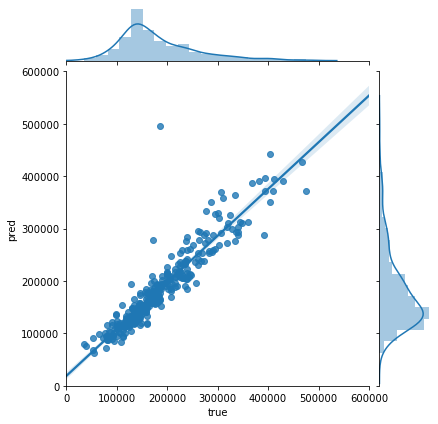

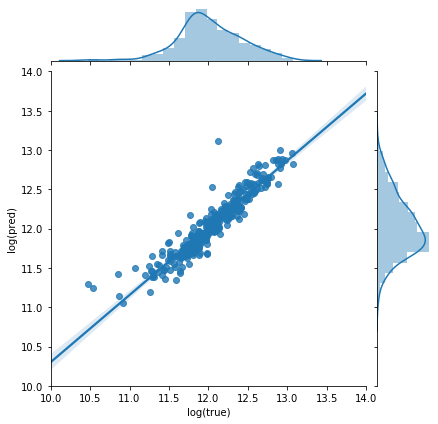

In [8]:
printTime('モデルの作成開始')

# 学習データを学習データとバリデーションデータに分ける
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(tr_x, tr_y)
lgb_eval = lgb.Dataset(va_x, va_y)

# ハイパーパラメータの設定
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'l2',
    'num_leaves': 40,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 2,
}

# 作成する決定木の数を指定
num_round = 100

# 学習の実行
# カテゴリ変数をパラメータで指定している
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params,
                  lgb_train,
                  num_boost_round=num_round,
                  categorical_feature=targets_category,
                  valid_names=['train', 'valid'],
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=5)

# バリデーションデータでのスコアの確認
va_pred = model.predict(va_x)

# バリデーションデータでのスコア(真の値の対数と予測値の対数の二乗平均平方根誤差 (RMSE))を計算する
rmse = np.sqrt(mean_squared_error(np.log(va_y), np.log(va_pred)))

print(f'RMSE: {rmse:.4f}')

# 結果の可視化
sns.jointplot(
    va_y,
    va_pred,
    kind="reg",
    xlim=(0, 600000),
    ylim=(0, 600000)
).set_axis_labels("true", "pred")

sns.jointplot(
    np.log(va_y),
    np.log(va_pred),
    kind="reg",
    xlim=(10, 14),
    ylim=(10, 14)
).set_axis_labels("log(true)", "log(pred)")

# 予測
pred = model.predict(test_x)


# 提出用ファイルの作成
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred})
submission.to_csv('/kaggle/output/submission_first.csv', index=False)

printTime('モデルの作成終了')